# Transfer Learning

### Import Libraries

In [220]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [221]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10249079154324963122
xla_global_id: -1
]


## Train with MonkeyPox Dataset

### Hyperparameters

In [ ]:
data_root = pathlib.Path("../data/Augmented_Images")    # points to the folder containing the images that will be used for training

# hyperparameters
img_height = 224        # input image height
img_width = 224         # input image width
batch_size = 32         # size of the batch that will be fed to model

# folds = the amount of folds that will be created for cross-validation
# fine_tune_epochs = number of epochs after which we start fine-tuning
# fine_tune_at = layer number where we start unfreezing layers

# configurations that will be used in training
configs = [
    {"model_name": "mobilenet", "learning_rate": 0.001, "batch_size": 32, "image_size" : 224, "optimizer": "adam", "epochs": 50, "save_metrics": True, "folds": 5, "fine_tune": False, "fine_tune_epochs": 25, "fine_tune_at": 150},
    {"model_name": "mobilenet", "learning_rate": 0.001, "batch_size": 32, "image_size" : 224, "optimizer": "adam", "epochs": 50, "save_metrics": True, "folds": 5, "fine_tune": False, "fine_tune_epochs": 25, "fine_tune_at": 150},
    {"model_name": "mobilenet", "learning_rate": 0.001, "batch_size": 32, "image_size" : 224, "optimizer": "adam", "epochs": 50, "save_metrics": True, "folds": 5, "fine_tune": False, "fine_tune_epochs": 25, "fine_tune_at": 150},
    {"model_name": "mobilenet", "learning_rate": 0.001, "batch_size": 32, "image_size" : 224, "optimizer": "adam", "epochs": 50, "save_metrics": True, "folds": 5, "fine_tune": False, "fine_tune_epochs": 25, "fine_tune_at": 150},
]

# Define the base path for saving models
save_dir = "../saved_models"
os.makedirs(save_dir, exist_ok=True)

## Training 

### Setup

In [223]:
def load_image_dataset(directory: str, batch_size: int, image_size: tuple[int, int],
                       label_mode, shuffle: bool = True) -> tf.data.Dataset:
    """
    Loads an image dataset from the specified directory using Keras' image_dataset_from_directory.

    The directory should contain one subdirectory per class.

    Args:
        directory (str): Path to the image data directory.
        batch_size (int): Number of images per batch.
        image_size (Tuple[int, int]): Target size (height, width) for the images.
        label_mode (str): Type of label encoding ('binary', 'categorical', or 'int'). Defaults to 'binary'.
        shuffle (bool): Whether to shuffle the data. Defaults to True.

    Returns:
        tf.data.Dataset: A dataset yielding batches of (image, label) pairs with images normalized.
    """
    # Load images and labels from the directory, inferring subdirectory names as class names.
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode="int",
        batch_size=batch_size,
        image_size=(image_size, image_size),
        shuffle=shuffle
    )
    # print(dataset.class_names)
    class_names = np.array(dataset.class_names)     # get the class names for the data
    # num_classes = len(class_names)                  # get the number of classes in the dataset
    # Normalize images to the [0, 1] range using a rescaling layer.
    normalization_layer = layers.Rescaling(1.0 / 255)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    # Cache and prefetch data to optimize performance.
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, class_names

from sklearn.utils import resample

def create_augmentation_layer() -> tf.keras.Sequential:
    """
    Creates a data augmentation pipeline using Keras layers.
    Augmentations include:
    - Random flipping (horizontal & vertical)
    - Small rotations
    - Zooming
    """
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),  # Random rotation (up to 20% of 360 degrees)
        tf.keras.layers.RandomZoom(0.1),  # Random zoom (up to 10% zoom)
        tf.keras.layers.RandomTranslation(0.1, 0.1),  # Random translation (up to 10% in both directions)
        # tf.keras.layers.GaussianNoise(0.1),  # Add Gaussian noise to the images
    ])

def oversample_minority_classes(images: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Oversamples minority classes by duplicating their samples up to the majority class count.

    Args:
        images (np.ndarray): Numpy array of images.
        labels (np.ndarray): Numpy array of labels.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Balanced images and labels.
    """
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    max_samples = max(class_counts)  # Find the class with the most images
    augmented_images, augmented_labels = [], []

    augmentation_layer = create_augmentation_layer()

    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]
        class_images = images[class_indices]
        class_labels = labels[class_indices]

        # Oversample minority classes
        while len(class_images) < max_samples:
            oversampled_images = resample(class_images, n_samples=min(max_samples - len(class_images), len(class_images)), replace=True)
            augmented_samples = augmentation_layer(oversampled_images, training=True)  # Apply augmentation
            class_images = np.concatenate([class_images, augmented_samples.numpy()], axis=0)

        augmented_images.append(class_images)
        augmented_labels.append(np.full(len(class_images), class_label))

    return np.concatenate(augmented_images, axis=0), np.concatenate(augmented_labels, axis=0)

def create_balanced_dataset(images: np.ndarray, labels: np.ndarray, batch_size: int = 32) -> tf.data.Dataset:
    """
    Creates a TensorFlow dataset from balanced images and labels, applying augmentation dynamically.

    Args:
        images (np.ndarray): Array of images.
        labels (np.ndarray): Array of labels.
        batch_size (int, optional): Batch size for training. Defaults to 32.

    Returns:
        tf.data.Dataset: TensorFlow dataset.
    """
    images, labels = oversample_minority_classes(images, labels)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(len(images))
    # dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def callbacks_setup(checkpoint_filepath):
    # EarlyStopping callback configuration
    early_stopping = EarlyStopping(
        monitor='val_loss',        # monitor validation loss
        patience=6,                # number of epochs with no improvement to stop training
        mode = 'min',              # want to minimize what it being monitored 
        restore_best_weights=False # don't restore in EarlyStopping, handled by ModelCheckpoint
    )

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,   # path to save weights
        save_weights_only=True,         # only save weights instead of full model
        monitor='val_loss',             # monitor validation loss
        mode='min',                     # want to maximize what is being monitored
        save_best_only=True             # save the best weights
    )            

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',      # monitor validation loss 
        factor=0.5,              # factor by which the learning rate will be reduced 
        patience=4,              # number of epochs with no improvement to stop training 
        mode='min',              # want to minimize what it being monitored 
        min_lr=1e-6              # lower bound on the learning rate 
    )            

    return early_stopping, model_checkpoint, reduce_lr

### Metrics

In [224]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Tuple, Dict, Any, List
from sklearn.metrics import (
    precision_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

def save_confusion_matrix(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                          class_names: List[str], save_path: str) -> None:
    """
    Plots and saves the confusion matrix for multi-class classification.

    Args:
        true_labels (np.ndarray): Array of true class labels.
        predicted_labels (np.ndarray): Array of predicted class labels.
        class_names (List[str]): List of class names corresponding to class indices.
        save_path (str): Path to save the confusion matrix plot.
    """
    # Compute confusion matrix using sklearn
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot with adjustments
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label", fontsize=12)
    ax.set_ylabel("True label", fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha='right')

    # Prevent labels from being cut off
    plt.tight_layout()

    # Save and close plot
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def save_loss_curve(history: Dict[str, Any], save_path: str) -> None:
    """
    Plots and saves the training and validation loss curves.

    Args:
        history (Dict[str, Any]): Dictionary containing training history (loss values).
        save_path (str): Path to save the loss curve plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def save_roc_auc(true_labels: np.ndarray, predicted_probs: np.ndarray, class_names: list, save_path: str = None):
    """
    Plots and saves the ROC AUC curve for multi-class classification.
    
    Args:
        true_labels (np.ndarray): True class labels.
        predicted_probs (np.ndarray): Predicted class probabilities.
        class_names (list): List of class names.
        save_path (str, optional): Path to save the ROC curve plot. Defaults to None.
    """
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def save_evaluation_metrics(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                            predicted_probs: np.ndarray, save_path: str) -> Dict[str, float]:
    """
    Computes evaluation metrics for multi-class classification and saves a bar chart.
    The metrics include accuracy, precision, recall, F1 score, and ROC AUC.

    Args:
        true_labels (np.ndarray): Array of true class labels.
        predicted_labels (np.ndarray): Array of predicted class labels.
        predicted_probs (np.ndarray): Array of predicted probabilities (shape: [n_samples, n_classes]).
        save_path (str): Path to save the evaluation metrics bar chart.

    Returns:
        Dict[str, float]: Dictionary containing computed metrics.
    """
    # Calculate accuracy by comparing predicted and true labels
    accuracy = np.mean(predicted_labels == true_labels)
    # Compute macro-averaged metrics for multi-class classification
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # For ROC AUC, first binarize the true labels to one-hot encoding
    n_classes = predicted_probs.shape[1]
    true_labels_binarized = label_binarize(true_labels, classes=list(range(n_classes)))
    # Compute ROC AUC with a one-vs-rest approach and macro average
    roc_auc = roc_auc_score(true_labels_binarized, predicted_probs, multi_class='ovr', average='macro')

    # Store metrics in a dictionary
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity (Recall)": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }

    # Plot metrics as a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics.keys(), metrics.values(), 
                   color=['darkturquoise', 'sandybrown', 'hotpink', 'limegreen', 'mediumpurple'])
    # Annotate each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.4f}', ha='center', va='bottom')
    plt.title("Model Evaluation Metrics")
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel("Score")
    plt.savefig(save_path)
    plt.close()

    return metrics

def save_classification_report(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                               class_names: List[str], save_path: str) -> None:
    """
    Saves the classification report to a text file for multi-class classification.

    Args:
        true_labels (np.ndarray): Array of true class labels.
        predicted_labels (np.ndarray): Array of predicted class labels.
        class_names (List[str]): List of class names.
        save_path (str): Path to save the classification report.
    """
    report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
    with open(save_path, "w") as f:
        f.write(report)

def calculate_metrics(true_labels: np.ndarray, predictions: np.ndarray) -> Tuple[float, float, float, float, float]:
    """
    Calculates evaluation metrics for multi-class classification.

    Args:
        true_labels (np.ndarray): Array of true class labels.
        predictions (np.ndarray): Array of predicted probabilities (shape: [n_samples, n_classes]).

    Returns:
        Tuple[float, float, float, float, float]: A tuple containing accuracy, precision, recall, 
            F1 score, and ROC AUC score.
    """
    # Convert predicted probabilities to predicted class labels using argmax
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Binarize true labels for ROC AUC calculation
    n_classes = predictions.shape[1]
    true_labels_binarized = label_binarize(true_labels, classes=list(range(n_classes)))
    auc = roc_auc_score(true_labels_binarized, predictions, multi_class='ovr', average='macro')

    return accuracy, precision, recall, f1, auc

def save_best_model_visuals(history: tf.keras.callbacks.History, model: tf.keras.Model, 
                              val_ds: tf.data.Dataset, class_names: List[str], 
                              weights_path: str, fold: int) -> None:
    """
    Generates and saves evaluation visuals including confusion matrix, loss curve, evaluation 
    metrics bar chart, and classification report for the best performing model in a given fold.

    Args:
        history (tf.keras.callbacks.History): Training history object.
        model (tf.keras.Model): Trained model.
        val_ds (tf.data.Dataset): Validation dataset.
        class_names (List[str]): List of class names.
        weights_path (str): Directory path to save visuals.
        fold (int): Current fold number.
    """
    # Generate predictions (predicted probabilities) for the validation set
    val_predictions = model.predict(val_ds)
    # Convert predicted probabilities to class labels using argmax
    val_predicted_ids = np.argmax(val_predictions, axis=1)
    # Concatenate true labels from the validation dataset
    true_labels = np.concatenate([y for _, y in val_ds], axis=0)

    # Save the confusion matrix
    confusion_matrix_path = os.path.join(weights_path, f"confusion_matrix_fold{fold}.png")
    save_confusion_matrix(true_labels, val_predicted_ids, class_names, confusion_matrix_path)

    # Save the loss curve using the training history
    loss_curve_path = os.path.join(weights_path, f"loss_curve_fold{fold}.png")
    save_loss_curve(history.history, loss_curve_path)

    # Save the roc auc curve using the training history
    roc_auc_curve_path = os.path.join(weights_path, f"roc_auc_curve_fold{fold}.png")
    save_roc_auc(true_labels, val_predictions, class_names, roc_auc_curve_path)

    # Save evaluation metrics bar chart (passing predicted probabilities for ROC AUC calculation)
    metrics_bar_chart_path = os.path.join(weights_path, f"evaluation_metrics_fold{fold}.png")
    save_evaluation_metrics(true_labels, val_predicted_ids, val_predictions, metrics_bar_chart_path)

    # Save the classification report as a text file
    classification_report_path = os.path.join(weights_path, f"classification_report_fold{fold}.txt")
    save_classification_report(true_labels, val_predicted_ids, class_names, classification_report_path)


In [225]:
def save_confusion_matrix_binary(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                          save_path: str, mpox_index: int = 0) -> None:
    """
    Converts multi-class labels to binary (Mpox vs Other) and plots/saves the confusion matrix.

    Args:
        true_labels (np.ndarray): Array of true class labels (multi-class integers).
        predicted_labels (np.ndarray): Array of predicted class labels (multi-class integers).
        save_path (str): Path to save the confusion matrix plot.
        mpox_index (int): The index corresponding to Mpox. All other labels are considered "Other".
    """
    # Convert multi-class labels to binary: 1 if label equals mpox_index, else 0.
    binary_true = (true_labels == mpox_index).astype(int)
    binary_pred = (predicted_labels == mpox_index).astype(int)
    cm = confusion_matrix(binary_true, binary_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "Mpox"])
    
    # Plot with adjustments
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label", fontsize=12)
    ax.set_ylabel("True label", fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha='right')

    # Prevent labels from being cut off
    plt.tight_layout()

    # Save and close plot
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def save_loss_curve_binary(history: Dict[str, Any], save_path: str) -> None:
    """
    Plots and saves the training and validation loss curves.

    Args:
        history (Dict[str, Any]): Dictionary containing training history (loss values).
        save_path (str): Path to save the loss curve plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def save_evaluation_metrics_binary(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                            predicted_probs: np.ndarray, save_path: str, 
                            mpox_index: int = 0) -> Dict[str, float]:
    """
    Computes and plots evaluation metrics for binary classification (Mpox vs Other).

    Args:
        true_labels (np.ndarray): Array of true class labels (multi-class integers).
        predicted_labels (np.ndarray): Array of predicted class labels (multi-class integers).
        predicted_probs (np.ndarray): Array of predicted probabilities for each class 
                                      (shape: [n_samples, n_classes]).
        save_path (str): Path to save the evaluation metrics bar chart.
        mpox_index (int): The index corresponding to Mpox.

    Returns:
        Dict[str, float]: Dictionary containing computed metrics.
    """
    # Convert to binary labels
    binary_true = (true_labels == mpox_index).astype(int)
    binary_pred = (predicted_labels == mpox_index).astype(int)
    # Use the probability for the Mpox class as the positive probability.
    mpox_probs = predicted_probs[:, mpox_index]

    accuracy = np.mean(binary_true == binary_pred)
    precision = precision_score(binary_true, binary_pred)
    recall = recall_score(binary_true, binary_pred)
    f1 = f1_score(binary_true, binary_pred)
    roc_auc = roc_auc_score(binary_true, mpox_probs)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity (Recall)": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }

    # Plot metrics as a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics.keys(), metrics.values(), 
                   color=['darkturquoise', 'sandybrown', 'hotpink', 'limegreen', 'mediumpurple'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.4f}', ha='center', va='bottom')
    plt.title("Evaluation Metrics (Mpox vs Other)")
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel("Score")
    plt.savefig(save_path)
    plt.close()

    return metrics

def save_classification_report_binary(true_labels: np.ndarray, predicted_labels: np.ndarray, 
                               save_path: str, mpox_index: int = 0) -> None:
    """
    Saves the classification report for binary classification (Mpox vs Other).

    Args:
        true_labels (np.ndarray): Array of true class labels (multi-class integers).
        predicted_labels (np.ndarray): Array of predicted class labels (multi-class integers).
        save_path (str): Path to save the classification report.
        mpox_index (int): The index corresponding to Mpox.
    """
    binary_true = (true_labels == mpox_index).astype(int)
    binary_pred = (predicted_labels == mpox_index).astype(int)
    report = classification_report(binary_true, binary_pred, target_names=["Other", "Mpox"], digits=4)
    with open(save_path, "w") as f:
        f.write(report)

def calculate_metrics_binary(true_labels: np.ndarray, predictions: np.ndarray, 
                      mpox_index: int = 0) -> Tuple[float, float, float, float, float]:
    """
    Calculates binary evaluation metrics for Mpox vs Other.
    The multi-class predictions are converted into binary predictions where the positive class 
    is Mpox (identified by mpox_index) and all other classes are negative.

    Args:
        true_labels (np.ndarray): Array of true class labels (multi-class integers).
        predictions (np.ndarray): Array of predicted probabilities (shape: [n_samples, n_classes]).
        mpox_index (int): The index corresponding to Mpox.

    Returns:
        Tuple[float, float, float, float, float]:
            Accuracy, Precision, Recall, F1 Score, and ROC AUC.
    """
    # Convert multi-class predictions to class indices
    predicted_labels_multi = np.argmax(predictions, axis=1)
    # Convert to binary: 1 if Mpox, 0 otherwise.
    binary_true = (true_labels == mpox_index).astype(int)
    binary_pred = (predicted_labels_multi == mpox_index).astype(int)
    mpox_probs = predictions[:, mpox_index]

    accuracy = np.mean(binary_true == binary_pred)
    precision = precision_score(binary_true, binary_pred)
    recall = recall_score(binary_true, binary_pred)
    f1 = f1_score(binary_true, binary_pred)
    auc = roc_auc_score(binary_true, mpox_probs)

    return accuracy, precision, recall, f1, auc

def save_best_model_visuals_binary(history: tf.keras.callbacks.History, model: tf.keras.Model, 
                              val_ds: tf.data.Dataset, weights_path: str, 
                              fold: int, mpox_index: int = 1) -> None:
    """
    Generates and saves evaluation visuals (confusion matrix, loss curve, metrics bar chart,
    and classification report) for binary classification (Mpox vs Other) for the best performing model.

    Args:
        history (tf.keras.callbacks.History): Training history object.
        model (tf.keras.Model): Trained model.
        val_ds (tf.data.Dataset): Validation dataset.
        weights_path (str): Directory path to save visuals.
        fold (int): Current fold number.
        mpox_index (int): The index corresponding to Mpox.
    """
    # Generate predictions for the validation set
    val_predictions = model.predict(val_ds)
    predicted_ids_multi = np.argmax(val_predictions, axis=1)
    true_labels = np.concatenate([y for _, y in val_ds], axis=0)
    
    # Save the confusion matrix
    confusion_matrix_path = os.path.join(weights_path, f"confusion_matrix_binary_fold{fold}.png")
    save_confusion_matrix_binary(true_labels, predicted_ids_multi, confusion_matrix_path, mpox_index)
    
    # Save the loss curve
    loss_curve_path = os.path.join(weights_path, f"loss_curve_binary_fold{fold}.png")
    save_loss_curve_binary(history.history, loss_curve_path)
    
    # Save evaluation metrics bar chart
    metrics_bar_chart_path = os.path.join(weights_path, f"evaluation_metrics_binary_fold{fold}.png")
    save_evaluation_metrics_binary(true_labels, predicted_ids_multi, val_predictions, metrics_bar_chart_path, mpox_index)
    
    # Save the classification report
    classification_report_path = os.path.join(weights_path, f"classification_report_binary_fold{fold}.txt")
    save_classification_report_binary(true_labels, predicted_ids_multi, classification_report_path, mpox_index)


### Model creation and fine tuning

In [ ]:
# Function to create and compile the model
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def create_model(num_classes: int, config: dict, fine_tune: bool = False) -> tf.keras.Model:
    """
    Creates a MobileNetV2-based model for multi-class classification.

    The model uses a pre-trained MobileNetV2 as a feature extractor (with ImageNet weights) 
    and adds a global average pooling layer followed by a dense layer that outputs logits 
    for each class. The model is compiled using SparseCategoricalCrossentropy (from_logits=True)
    which is appropriate for multi-class classification.

    Args:
        num_classes (int): Number of classes for classification.
        config (dict): Configuration dictionary containing:
            - "image_size": Tuple[int, int] representing the target (height, width) for images.
            - "optimizer": Optimizer name ("adam" or "sgd").
            - "learning_rate": Learning rate for the optimizer.
        fine_tune (bool, optional): If True, the base model will be set as trainable for fine-tuning.
                                    Otherwise, the base model is frozen. Defaults to False.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    # Instantiate the MobileNetV2 base model with pre-trained ImageNet weights.
    # Exclude the top layer to allow for transfer learning.

    model_name = config["model_name"]

    if model_name == "mobilenet":
        base_model = tf.keras.applications.MobileNetV2
    elif model_name == "efficientnet":
        base_model = tf.keras.applications.EfficientNetB3
    elif model_name == "densenet":
        base_model = tf.keras.applications.DenseNet121
    elif model_name == "inceptionv3":
        base_model = tf.keras.applications.InceptionV3
    elif model_name == "resnet50":
        base_model = tf.keras.applications.ResNet50
    elif model_name == "vgg16":
        base_model = tf.keras.applications.VGG16
    elif model_name == "xception":
        base_model = tf.keras.applications.Xception
    else:
        raise ValueError(f"Model name '{model_name}' is not supported.")


    base_model = base_model(
        input_shape=(config["image_size"], config["image_size"], 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Set the trainability of the base model based on the fine_tune flag.
    base_model.trainable = False

    # data_augmentation = tf.keras.Sequential([
    #     layers.RandomFlip("horizontal"),
    #     layers.RandomRotation(0.1),
    #     layers.RandomZoom(0.1)
    # ])

    # Build the model using the Keras Sequential API.
    # For multi-class classification, the final Dense layer outputs 'num_classes' logits.
    model = Sequential([
        # data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        # Dropout layer to randomly drop 50% of the neurons during training
        # layers.Dropout(0.25),
        # Dense layer with L2 regularization
        # layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        layers.Dense(num_classes)
    ])

    # Select the optimizer based on configuration.
    if config["optimizer"] == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    # Compile the model with SparseCategoricalCrossentropy loss which expects logits.
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model


# fine tune model by unfreezing the layers after the first fine_tune_at layers
def fine_tune_model(base_model, fine_tune_at):
    # Unfreeze the layers starting from fine_tune_at index
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True


### Train Fold

In [227]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

def train_fold(fold: int, config: dict, best_f1_score: float, best_f1_dir: str, model_subdir: str) -> float:
    """
    Trains and evaluates a model for one fold of the dataset using images from the specified folders.
    
    Training images are loaded from 'Augmented Images/Fold{fold}/train',
    validation images from 'Original Images/Fold{fold}/val', and test images from 'Original Images/Fold{fold}/test'.
    
    Args:
        fold (int): The fold number to process.
        config (dict): Configuration parameters including hyperparameters and paths.
        best_f1_score (float): The best F1 score recorded so far.
        best_f1_dir (str): Directory where the best model is saved.
        model_subdir (str): Subdirectory for saving additional visuals and metrics.
    
    Returns:
        float: The updated best F1 score after processing the current fold.
    """
    # Define directory paths for the current fold
    # augmented_train_dir = os.path.join("../data", "archive", "Augmented Images", "Augmented Images", "FOLDS_AUG", f"fold{fold}_AUG", "Train")
    augmented_train_dir = os.path.join("../data", "archive", "Original Images", "Original Images", "FOLDS", f"fold{fold}", "Train")
    original_val_dir = os.path.join("../data", "archive", "Original Images", "Original Images", "FOLDS", f"fold{fold}", "Valid")
    original_test_dir = os.path.join("../data", "archive", "Original Images", "Original Images", "FOLDS", f"fold{fold}", "Test")

    print(f"\nProcessing Fold {fold}...")

    # Load the training, validation, and test datasets
    train_ds, class_names = load_image_dataset(augmented_train_dir, config['batch_size'],
                                  config['image_size'], label_mode=config.get('label_mode', 'int'), shuffle=True)
    val_ds, _ = load_image_dataset(original_val_dir, config['batch_size'],
                                config['image_size'], label_mode=config.get('label_mode', 'int'), shuffle=False)
    test_ds, _ = load_image_dataset(original_test_dir, config['batch_size'],
                                 config['image_size'], label_mode=config.get('label_mode', 'int'), shuffle=False)
    
    # --- Compute class weights using sklearn ---
    # Extract the labels from the training dataset.
    # Note: train_ds is a tf.data.Dataset yielding (images, labels)
    train_labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
    # Compute the class weights
    classes = np.unique(train_labels)
    computed_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
    # Create a dictionary mapping each class index to its weight.
    class_weight_dict = {int(cls): weight for cls, weight in zip(classes, computed_weights)}
    print("Class Weight Dictionary:", class_weight_dict)
    
    images, labels = [], []
    # Iterate over the dataset
    for batch_images, batch_labels in train_ds:
        for img, lbl in zip(batch_images, batch_labels):  # Extract each image-label pair
            images.append(img)
            labels.append(lbl)

    # Ensure all images are stacked correctly
    images = np.array(tf.stack(images))  # Now all images should have the same shape
    labels = np.array(labels)  # Convert labels to a NumPy array

    train_ds = create_balanced_dataset(images, labels)

    # Initialize dictionary to count samples per class
    class_counts = Counter()

    # Iterate through dataset and update class counts
    for _, labels in train_ds:
        class_counts.update(labels.numpy())  # Convert tensor to NumPy array and count occurrences

    # Print the class distribution
    print("Sample count per class in balanced dataset:")
    for class_label, count in sorted(class_counts.items()):
        print(f"Class {class_label}: {count} samples")

    print("______________________________________________")


    # Set up a filepath for model checkpointing for this fold
    checkpoint_filepath = os.path.join(config['checkpoint_folder'], f'checkpoint_fold{fold}.weights.h5')

    # -------------------- Step 1: Train with Frozen Base Layers --------------------
    print(f"Training with frozen base layers for {config['epochs']} epochs on Fold {fold}...")

    # Create the model for this fold (replace create_model with your actual model creation function)
    model = create_model(len(class_names), config, fine_tune=False)
    
    # Setup callbacks (replace callbacks_setup with your callback setup function)
    early_stopping, model_checkpoint, reduce_lr = callbacks_setup(checkpoint_filepath)
    
    # Train the model using the training and validation datasets, including class weights
    history_frozen = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config['epochs'],
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    # Load the best weights saved during training
    model.load_weights(checkpoint_filepath)

    # -------------------- Step 2: Fine-Tuning (Optional) --------------------
    if config.get("fine_tune", False):
        print(f"Unfreezing layers starting from layer {config['fine_tune_at']} for fine-tuning on Fold {fold}...")
        fine_tune_model(model.layers[0], config['fine_tune_at'])
        # Set a lower learning rate for fine-tuning
        fine_tune_lr = config['learning_rate'] * 0.01
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print(f"Fine-tuning for {config['fine_tune_epochs']} epochs on Fold {fold}...")
        early_stopping, model_checkpoint, reduce_lr = callbacks_setup(checkpoint_filepath)
        history_fine_tune = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=config['fine_tune_epochs'],
            callbacks=[early_stopping, model_checkpoint, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )
        # Load the best weights after fine-tuning
        model.load_weights(checkpoint_filepath)

    # -------------------- Evaluation on Validation Dataset --------------------
    # Get predictions and compute metrics on the validation dataset
    val_predictions = model.predict(val_ds)
    avg_val_loss = model.evaluate(val_ds, verbose=0)[0]
    avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = calculate_metrics(
        np.concatenate([y for _, y in val_ds]),  # combine labels from val_ds
        val_predictions
    )

    print(f"\nFold {fold} Validation Metrics:")
    print(f"  Loss: {avg_val_loss:.4f}")
    print(f"  Accuracy: {avg_val_accuracy:.4f}")
    print(f"  Precision: {avg_val_precision:.4f}")
    print(f"  Recall: {avg_val_recall:.4f}")
    print(f"  F1 Score: {avg_val_f1:.4f}")
    print(f"  ROC AUC Score: {avg_val_auc:.4f}")

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
    print(f"Fold {fold} Test Metrics: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    # -------------------- Optional: Evaluation on Test Dataset --------------------
    # If this fold produces the best F1 score so far, save the model and visuals
    if avg_val_f1 > best_f1_score:
        best_f1_score = avg_val_f1
        # Save the best model (using model.export for TensorFlow SavedModel format)
        model.export(best_f1_dir)
        print(f"Best model updated at Fold {fold} with F1 Score: {best_f1_score:.4f}")
        if config.get('save_metrics', False):
            save_best_model_visuals(history_frozen, model, test_ds, class_names, model_subdir, fold)
            save_best_model_visuals_binary(history_frozen, model, test_ds, model_subdir, fold, 5)
    return best_f1_score


### Training loop

In [228]:
def main_training_loop(config: dict, best_f1_dir: str, model_subdir: str) -> None:
    """
    Main loop that iterates over each fold, training and evaluating the model.

    Args:
        config (dict): Configuration parameters including hyperparameters and training settings.
        num_classes (int): Number of classes in the classification task.
        best_f1_dir (str): Directory to save the best performing model.
        model_subdir (str): Subdirectory for saving additional metrics and visuals.
        class_names (List[str]): List of class names.

    Returns:
        None
    """
    best_val_f1score = 0.0
    total_folds = config.get('folds', 5)  # default to 5 folds if not specified

    # Iterate through each fold and update the best F1 score if improved.
    for fold in range(1, total_folds + 1):
        best_val_f1score = train_fold(fold, config, best_val_f1score,
                                      best_f1_dir, model_subdir)
    print(f"\nTraining complete. Best Validation F1 Score: {best_val_f1score:.4f}")

## Train

In [229]:
for i, config in enumerate(configs):
    # Define the base path for saving models
    model_subdir = os.path.join(save_dir, f'model{i + 1}')
    os.makedirs(model_subdir, exist_ok=True)

    # Define the base path for saving cthe model with the best f1-score
    best_f1_dir = os.path.join(model_subdir, 'best_f1score_fold')
    os.makedirs(best_f1_dir, exist_ok=True)

    # Define the base path for saving checkpoints for model
    checkpoint_folder = os.path.join(model_subdir, 'checkpoints')
    os.makedirs(checkpoint_folder, exist_ok=True)
    
    config['checkpoint_folder'] = checkpoint_folder

    main_training_loop(configs[i], best_f1_dir, model_subdir)


Processing Fold 1...
Found 537 files belonging to 6 classes.
Found 144 files belonging to 6 classes.
Found 74 files belonging to 6 classes.
Class Weight Dictionary: {0: 1.79, 1: 1.8265306122448979, 2: 0.771551724137931, 3: 1.0783132530120483, 4: 2.418918918918919, 5: 0.4430693069306931}
Sample count per class in balanced dataset:
Class 0: 202 samples
Class 1: 202 samples
Class 2: 202 samples
Class 3: 202 samples
Class 4: 202 samples
Class 5: 202 samples
______________________________________________
Training with frozen base layers for 50 epochs on Fold 1...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.2912 - loss: 2.2469 - val_accuracy: 0.4028 - val_loss: 1.6695 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.6723 - loss: 0.9160 - val_accuracy: 0.5069 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.7684 - loss: 0.6302 - val_accuracy: 0.5000 - val_loss: 1.2645 -

INFO:tensorflow:Assets written to: ../saved_models\model1\best_f1score_fold\assets


Saved artifact at '../saved_models\model1\best_f1score_fold'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_7718')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1538272137424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272136080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272136464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272135696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272137040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272135888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272148368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272145680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272135312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272138192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15382

INFO:tensorflow:Assets written to: ../saved_models\model1\best_f1score_fold\assets


Saved artifact at '../saved_models\model1\best_f1score_fold'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_7881')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1535100368848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100366544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100370000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100368080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100356752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1538272614864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100367696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535220037200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100363856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100365776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15352

INFO:tensorflow:Assets written to: ../saved_models\model1\best_f1score_fold\assets


Saved artifact at '../saved_models\model1\best_f1score_fold'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_8370')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1531702070352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241581712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241579984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1535100360400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241578640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1537440497936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241566928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241571920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536241580560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536172194512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15374

Found 537 files belonging to 6 classes.
Fold 1 - Train Set Class Distribution:
Class 0: 50 samples
Class 1: 49 samples
Class 2: 116 samples
Class 3: 83 samples
Class 4: 37 samples
Class 5: 202 samples


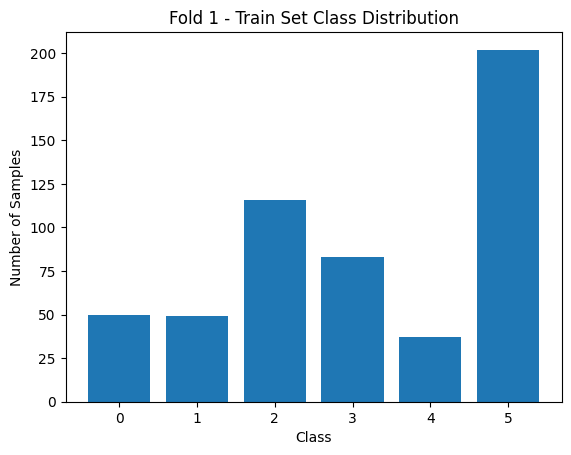

Found 144 files belonging to 6 classes.
Fold 1 - Valid Set Class Distribution:
Class 0: 16 samples
Class 1: 10 samples
Class 2: 29 samples
Class 3: 22 samples
Class 4: 12 samples
Class 5: 55 samples


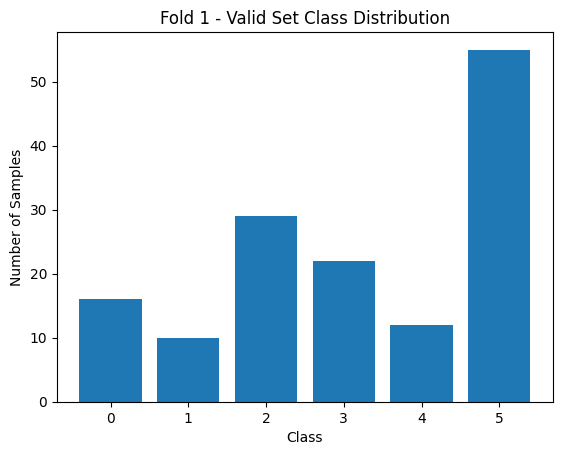

Found 74 files belonging to 6 classes.
Fold 1 - Test Set Class Distribution:
Class 0: 9 samples
Class 1: 7 samples
Class 2: 16 samples
Class 3: 9 samples
Class 4: 6 samples
Class 5: 27 samples


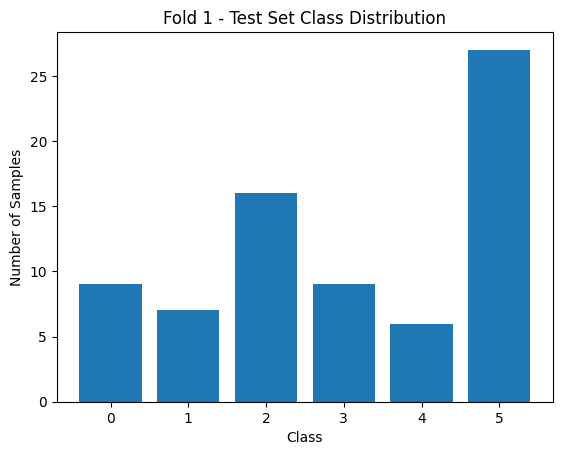

In [40]:
def print_class_distribution(fold_dirs: list):
    """
    Prints and plots the class distribution for training, validation, and test sets across folds.
    
    Args:
        fold_dirs (list): List of directory paths for each fold.
    """
    for fold, fold_dir in enumerate(fold_dirs, 1):
        for split in ['Train', 'Valid', 'Test']:
            split_dir = os.path.join(fold_dir, split)
            dataset = tf.keras.preprocessing.image_dataset_from_directory(
                split_dir,
                labels='inferred',
                label_mode='int',
                batch_size=32,
                image_size=(224, 224),
                shuffle=False
            )
            labels = np.concatenate([y.numpy() for _, y in dataset], axis=0)
            unique_classes, class_counts = np.unique(labels, return_counts=True)
            
            print(f"Fold {fold} - {split} Set Class Distribution:")
            for cls, count in zip(unique_classes, class_counts):
                print(f"Class {cls}: {count} samples")
            
            plt.figure()
            plt.bar(unique_classes, class_counts)
            plt.xlabel("Class")
            plt.ylabel("Number of Samples")
            plt.title(f"Fold {fold} - {split} Set Class Distribution")
            plt.show()

print_class_distribution(["../data/archive/Original Images/Original Images/FOLDS/fold1",
                        #   "../data/archive/Original Images/Original Images/FOLDS/fold2",
                        #   "../data/archive/Original Images/Original Images/FOLDS/fold3",
                        #   "../data/archive/Original Images/Original Images/FOLDS/fold4",
                        #   "../data/archive/Original Images/Original Images/FOLDS/fold5"
                        ])